# ISTA: Applied Deep Learning for Scientists -- Homework 1

This homework consists of two theoretical questions and one practical question. 

- For the theoretical questions, you can type out the answers in cells dedicated for the answers (Markdown supports LaTeX equations).
- For the practical question, please fill in the missing blocks of code.

Please submit the homeworks via email to all the TAs.

**Deadline**: March 18, 2024, 11:55 PM.

**TAs**: Dingling Yao (`dingling.yao@ist.ac.at`), Valentino Maiorca (`valentino.maiorca@ist.ac.at`), Sanketh Vedula (`sanketh@campus.technion.ac.il`)


```
Name: <your name>

ID: <your ID>
```

## Question 1: Backpropagation

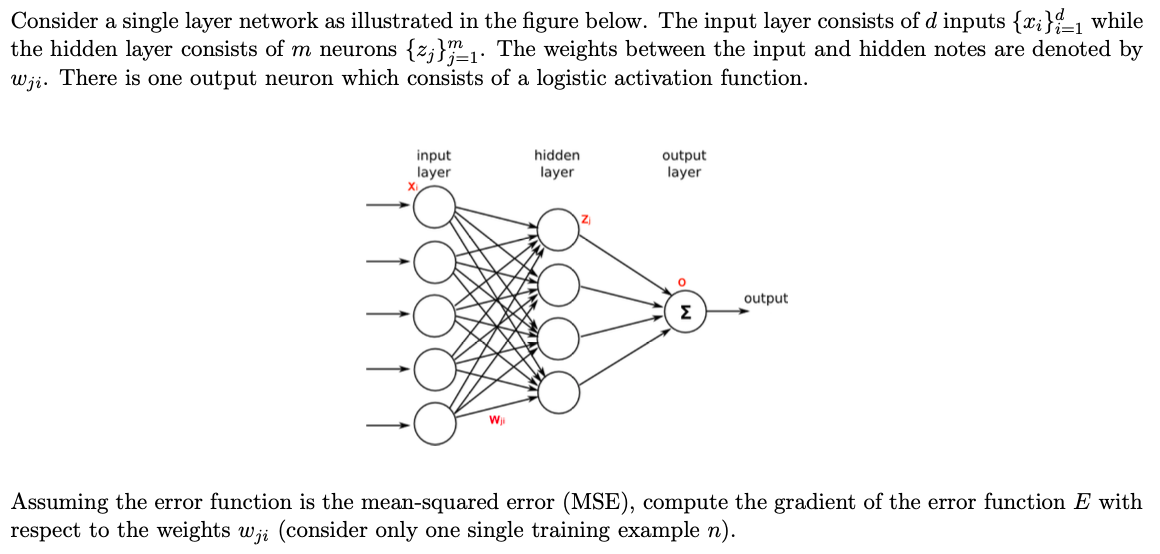

## Answer 1: 

Please fill in the answer here.

## Question 2: Numerics of CNNs

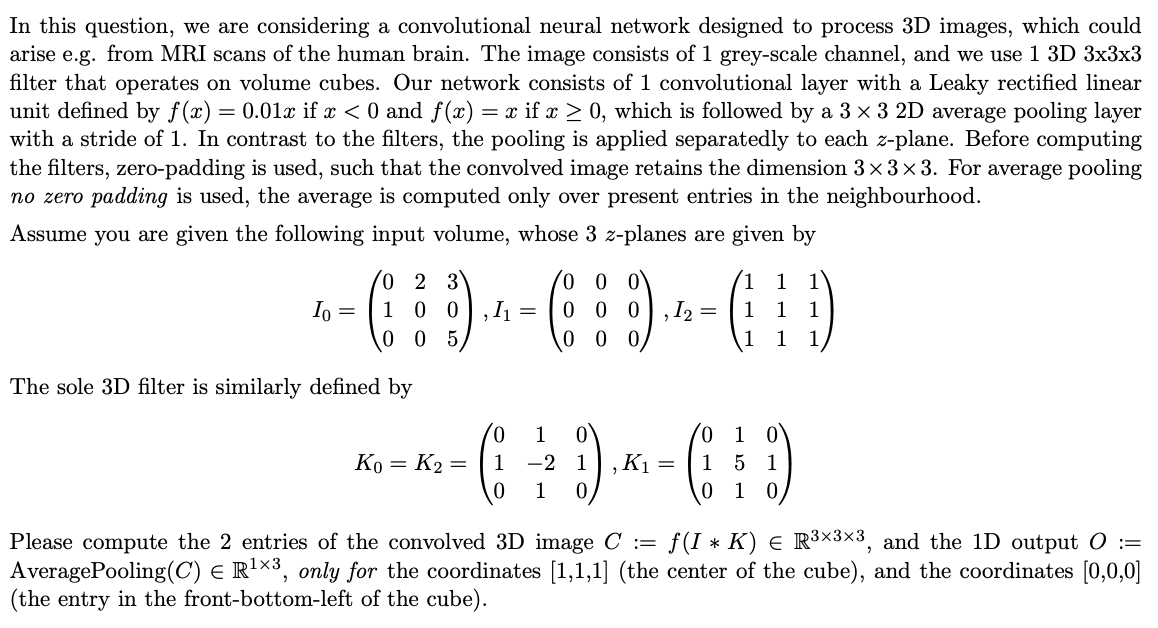

## Answer 2:

Please fill in the answer here.

## Question 3: MLP vs CNN (pratical)

Below in the notebook, we will define and compare two types of neural network models using PyTorch, namely, an MLP and a CNN. Please perform the following steps:

1. Implement the aforementioned models in PyTorch. The CNN should be designed with fewer trainable parameters than the MLP.
2. Train both MLP and CNN models on the CIFAR-10 dataset.
3. Create a single pixel permutation pattern and apply it to scramble the CIFAR-10 dataset. Apply this pattern and retrain both models on the altered dataset.
4. Evaluate and compare the performance of both models on the original and scrambled versions of the CIFAR-10 dataset. Discuss which model performs better and why.
5. Implement or discuss the potential effects for both architectures of using independent pixel shuffling for each image in the dataset.

Partial implementation with missing code blocks is provided below, please fill in with content as appropriate.

### Q3: Import dependencies

In [ ]:
!pip install plotly==5.3.1

In [ ]:
# @title import dependencies

from typing import Mapping, Union, Optional

import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.graph_objects as go
import torchvision
from torchvision import datasets, models, transforms
import os
from tqdm.notebook import tqdm

from __future__ import print_function, division

In [ ]:
# @title reproducibility stuff

import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False

### Q3:Load the dataset CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

We will use some PyTorch utilities to download, shuffle, normalize the data and arrange it in batches.


In [ ]:
# Totally arbitrary transformations
# You can do better! e.g. compute the mean and std of the train dataset
image_transforms = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,)),
    ]
)

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        "../data",
        train=True,
        download=True,
        transform=image_transforms
    ),
    batch_size=64,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        "../data",
        train=False,
        transform=image_transforms
    ),
    batch_size=1000,
    shuffle=True,
)

# Retrieve the image size and the number of color channels
x, _ = next(iter(train_loader))

n_channels = x.shape[1]
input_size_w = x.shape[2]
input_size_h = x.shape[3]
input_size = input_size_w * input_size_h

# Specify the number of classes in CIFAR10
output_size = 10  # there are 10 classes
output_classes = ('plane', 'car', 'bird', 'cat', 'deer',
                  'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# We can still access our dataset
train_loader.dataset

In [ ]:
# @title Dataset examples { run: "auto" }

import plotly.express as px

training_index = 10704  #@param {type:"slider", min:0, max:50000, step:1}
image, label = train_loader.dataset[training_index]

antbee_example = np.array(image[0])

fig = px.imshow(antbee_example,
                title=output_classes[label],
                color_continuous_scale='gray',
                color_continuous_midpoint=0)
fig.show()

# **Exercise**: define the model classes


In [ ]:
class FC2Layer(nn.Module):
    def __init__(
        self, input_size: int, input_channels: int, n_hidden: int, output_size: int
    ) -> None:
        """
        Simple MLP model

        :param input_size: number of pixels in the image
        :param input_channels: number of color channels in the image
        :param n_hidden: size of the hidden dimension to use
        :param output_size: expected size of the output
        """
        super().__init__()
        # TODO: implement

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param x: batch of images with size [batch, 1, w, h]

        :returns: predictions with size [batch, output_size]
        """
        # TODO: implement



class CNN(nn.Module):
    def __init__(
        self, input_size: int, input_channels: int, n_feature: int, output_size: int
    ) -> None:
        """
        Simple model that uses convolutions

        :param input_size: number of pixels in the image
        :param input_channels: number of color channels in the image
        :param n_feature: size of the hidden dimensions to use
        :param output_size: expected size of the output
        """
        super().__init__()
        # TODO: implement


    def forward(self,
                x: torch.Tensor,
                return_conv1: bool = False,
                return_conv2: bool = False,
                return_conv3: bool = False
        ) -> torch.Tensor:
        """
        :param x: batch of images with size [batch, 1, w, h]
        :param return_conv1: if True return the feature maps of the first convolution
        :param return_conv2: if True return the feature maps of the second convolution
        :param return_conv3: if True return the feature maps of the third convolution

        :returns: predictions with size [batch, output_size]
        """
        # TODO: implement


# A fixed sample batch
# x, _ = next(iter(train_loader))
# model = CNN(input_size, n_channels, 9, 10)
# _ = model(x)

In [ ]:
# You can skip this cell and read only the function docstring

import torch
import torch.nn.functional as F
from typing import Optional, Callable, Dict
from tqdm.notebook import tqdm, trange


def count_parameters(model: torch.nn.Module) -> int:
  """ Counts the number of trainable parameters of a module

  :param model: model that contains the parameters to count
  :returns: the number of parameters in the model
  """
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

def permute_pixels(images: torch.Tensor, perm: Optional[torch.Tensor]) -> torch.Tensor:
    """ Permutes the pixel in each image in the batch

    :param images: a batch of images with shape [batch, channels, w, h]
    :param perm: a permutation with shape [w * h]

    :returns: the batch of images permuted according to perm
    """
    if perm is None:
        return images

    batch_size = images.shape[0]
    n_channels = images.shape[1]
    w = images.shape[2]
    h = images.shape[3]
    images = images.view(batch_size, n_channels, -1)
    images = images[..., perm]
    images = images.view(batch_size, n_channels, w, h)
    return images


def make_averager() -> Callable[[Optional[float]], float]:
    """ Returns a function that maintains a running average

    :returns: running average function
    """
    count = 0
    total = 0

    def averager(new_value: Optional[float]) -> float:
        """ Running averager

        :param new_value: number to add to the running average,
                          if None returns the current average
        :returns: the current average
        """
        nonlocal count, total
        if new_value is None:
            return total / count if count else float("nan")
        count += 1
        total += new_value
        return total / count

    return averager

def test_model(
    test_dl: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    perm: Optional[torch.Tensor] = None,
    device: str = "cuda",
) -> Dict[str, Union[float, Callable[[Optional[float]], float]]]:
    """Compute model accuracy on the test set

    :param test_dl: the test dataloader
    :param model: the model to train
    :param perm: if not None, permute the pixel in each image according to perm

    :returns: computed accuracy
    """
    model.eval()
    test_loss_averager = make_averager()  # mantain a running average of the loss
    correct = 0
    for data, target in test_dl:
        # send to device
        data, target = data.to(device), target.to(device)

        if perm is not None:
            data = permute_pixels(data, perm)

        output = model(data)

        test_loss_averager(F.cross_entropy(output, target))

        # get the index of the max probability
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).cpu().sum().item()

    return {
        "accuracy": 100.0 * correct / len(test_dl.dataset),
        "loss_averager": test_loss_averager,
        "correct": correct,
    }

def fit(
    epochs: int,
    train_dl: torch.utils.data.DataLoader,
    test_dl: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    opt: torch.optim.Optimizer,
    tag: str,
    perm: Optional[torch.Tensor] = None,
    device: str = "cuda",
) -> float:
    """Train the model and computes metrics on the test_loader at each epoch

    :param epochs: number of epochs
    :param train_dl: the train dataloader
    :param test_dl: the test dataloader
    :param model: the model to train
    :param opt: the optimizer to use to train the model
    :param tag: description of the current model
    :param perm: if not None, permute the pixel in each image according to perm

    :returns: accucary on the test set in the last epoch
    """
    for epoch in trange(epochs, desc="train epoch"):
        model.train()
        train_loss_averager = make_averager()  # mantain a running average of the loss

        # TRAIN
        tqdm_iterator = tqdm(
            enumerate(train_dl),
            total=len(train_dl),
            desc=f"batch [loss: None]",
            leave=False,
        )
        for batch_idx, (data, target) in tqdm_iterator:
            # send to device
            data, target = data.to(device), target.to(device)

            if perm is not None:
                data = permute_pixels(data, perm)

            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss_averager(loss.item())

            tqdm_iterator.set_description(
                f"train batch [avg loss: {train_loss_averager(None):.3f}]"
            )
            tqdm_iterator.refresh()

        # TEST
        test_out = test_model(test_dl, model, perm, device)

        print(
            f"Epoch: {epoch}\n"
            f"Train set: Average loss: {train_loss_averager(None):.4f}\n"
            f"Test set: Average loss: {test_out['loss_averager'](None):.4f}, "
            f"Accuracy: {test_out['correct']}/{len(test_dl.dataset)} "
            f"({test_out['accuracy']:.0f}%)\n"
        )
    models_accuracy[tag] = test_out['accuracy']
    return test_out['accuracy']



def get_model_optimizer(model: torch.nn.Module) -> torch.optim.Optimizer:
    """
    Encapsulate the creation of the model's optimizer, to ensure that we use the
    same optimizer everywhere

    :param model: the model that contains the parameter to optimize

    :returns: the model's optimizer
    """
    return optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    # return optim.SGD(model.parameters(), lr=0.01, momentum=0.1, weight_decay=1e-5)


Training hyperparameters:

In [ ]:
# Define the number of the epochs
epochs = 4

# Number of hidden units for the MLP
n_hidden = 9

# Number of the feature maps in the CNN
n_features = 6

device = 'cuda'

# Define a dictionary that will contain the performance of the different models
models_accuracy = {}

## CIFAR-10

In this section we will train our MLP and CNN on the train set of the CIFAR-10,
and evaluate them on the test set.

### Small fully-connected network

In [ ]:
model_fnn = FC2Layer(input_size, n_channels, n_hidden, output_size)
model_fnn.to(device)
optimizer = get_model_optimizer(model_fnn)

print(f'Number of parameters: {count_parameters(model_fnn)}')

fit(epochs=epochs,
    train_dl=train_loader,
    test_dl=test_loader,
    model=model_fnn,
    opt=optimizer,
    tag='fnn',
    device=device)

### ConvNet with less parameters


In [ ]:
model_cnn = CNN(input_size, n_channels, n_features, output_size)
model_cnn.to(device)
optimizer = get_model_optimizer(model_cnn)

print(f'Number of parameters: {count_parameters(model_cnn)}')

fit(epochs=epochs,
    train_dl=train_loader,
    test_dl=test_loader,
    model=model_cnn,
    opt=optimizer,
    tag='cnn',
    device=device)

The ConvNet performs better with **fewer parameters**, thanks to its use of priors!

In [ ]:
print(f'FNN number of parameters: {count_parameters(model_fnn)}')
print(f'CNN number of parameters: {count_parameters(model_cnn)}')

##  Scrambled CIFAR-10


We will use a fixed permutation to shuffle the pixels:

In [ ]:
# Define a permutation of the pixels
perm = torch.randperm(input_size)
perm

In [ ]:
# @title Scrambled dataset examples { run: "auto" }

import plotly.express as px

training_index = 16613  #@param {type:"slider", min:0, max:50000, step:1}

image, label = train_loader.dataset[training_index]
image_perm = permute_pixels(image[None, :], perm).squeeze(dim=0)

# To plot a colored image, just use: torch.einsum('cwh -> whc', image)
fig = px.imshow(image[0],
                title=output_classes[label],
                color_continuous_scale='gray',
                color_continuous_midpoint=0
                )
fig.show()

fig = px.imshow(image_perm[0],
                title=f'Scrambled {output_classes[label]}',
                color_continuous_scale='gray',
                color_continuous_midpoint=0)
fig.show()

### Small fully-connected network

In [ ]:
model_scrambled_fnn = FC2Layer(input_size, n_channels, n_hidden, output_size)
model_scrambled_fnn.to(device)
optimizer = get_model_optimizer(model_scrambled_fnn)

print(f'Number of parameters: {count_parameters(model_scrambled_fnn)}')

fit(epochs=epochs,
    train_dl=train_loader,
    test_dl=test_loader,
    model=model_scrambled_fnn,
    opt=optimizer,
    tag='scrambled_fnn',
    perm=perm,   # <----- permute the images
    device=device)

### ConvNet with less parameters


In [ ]:
model_scrambled_cnn = CNN(input_size, n_channels, n_features, output_size)
model_scrambled_cnn.to(device)
optimizer = get_model_optimizer(model_scrambled_cnn)

print(f'Number of parameters: {count_parameters(model_scrambled_cnn)}')

fit(epochs=epochs,
    train_dl=train_loader,
    test_dl=test_loader,
    model=model_scrambled_cnn,
    opt=optimizer,
    tag='scrambled_cnn',
    perm=perm,  # permute the images
    device=device)

## Performance comparison




In [ ]:
import plotly.express as pe
import plotly.graph_objects as go

tags = ('fnn', 'cnn', 'scrambled_cnn', 'scrambled_fnn')
accuracy_list = [models_accuracy[tag] for tag in
                 tags]

fig = go.Figure([go.Bar(x=tags, y=accuracy_list)])
fig.update_layout(title='Performance comparison',
                  yaxis_title="Accuracy [%]",
                  xaxis_title="Model type")
fig.show()